<footer id="footer"></footer>

<h1 align='center'>Text classification</h1>

<p align="center"><img src="https://drive.google.com/uc?id=1_z-c_-EZvp_AqiPlrJDKoda80dwMPLt8" alt="w2v" border="0"></a></p>




В этом задании нам предстоит попробовать несколько методов, используемых в задаче классификации, а также понять насколько хорошо модель понимает смысл слов и какие слова в примере влияют на результат.







<b> **Baseline** подготовлен [Deep learning school](#https://www.dlschool.org/pro-track)

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___




## Классификация текстов



In [ ]:
!pip install -q captum

In [ ]:
import pandas as pd
import numpy as np
import torch
import math

from torchtext.legacy import datasets
from torchtext.legacy import data
from torchtext.vocab import Vectors, GloVe

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from tqdm.autonotebook import tqdm

from sklearn.metrics import (
                              f1_score, 
                              precision_recall_curve, 
                              precision_score, 
                              recall_score
)

import copy
import matplotlib.pyplot as plt
from captum.attr import (
                          LayerIntegratedGradients, 
                          TokenReferenceBase, 
                          visualization
)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# для проверки метрик: precision, recall, f1, pr-curve

def make_metrics(model, test_loader, grid=True, padded=False):
  model.eval()
  for threshold in np.arange(0, 0.95, 0.05):
    y_pred = []
    y_true = []
    pbar = tqdm(enumerate(test_loader), total=len(test_loader), leave=False)
    for _, batch in pbar:
      labels = batch.label.unsqueeze(1)
      features, text_len = batch.text
      if padded: 
        outputs = model(features, text_len)
      else:
        outputs = model(features)
      probs = torch.sigmoid(outputs)
      y_preds = ((probs > threshold) * 1.)
      y_pred.extend(y_preds.detach().to('cpu').numpy())
      y_true.extend(labels.to('cpu').numpy())
    f_score = f1_score(y_true, y_pred)
    if threshold == .5:
      f1 = f_score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f} | F1-мера = {:.3f}".format(
          threshold, precision, recall, f_score))
    
  print(f"\033[1mМера для стандартного порога: {f1:.2f}\033[0m")

  y_probs = []
  y_true = []

  pbar = tqdm(enumerate(test_loader), total=len(test_loader), leave=False)
  with plt.style.context('dark_background'):
    for _, batch in pbar:
      labels = batch.label.unsqueeze(1)
      features, text_len = batch.text
      if padded: 
        outputs = model(features, text_len)
      else:
        outputs = model(features)
      probs = torch.sigmoid(outputs)
      y_probs.extend(probs.detach().to('cpu').numpy())
      y_true.extend(labels.to('cpu').numpy())

    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)    
    plt.figure(figsize=(10, 10))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('PR кривая')
    plt.grid(grid)
    plt.show() 


In [ ]:
def cnt_params(model):
  """для подсчета параметров модели"""
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

 
# для интерпритации моделей

def forward_with_softmax(inp):
    logits = model(inp)
    return torch.softmax(logits, 0)[0][1]

def forward_with_sigmoid(input):
    return torch.sigmoid(model(input))

def interpret_sentence(model, sentence, min_len = 7, label = 0):
    model.eval()
    text = [tok for tok in TEXT.tokenize(sentence)]
    if len(text) < min_len:
        text += ['pad'] * (min_len - len(text))
    indexed = [TEXT.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    seq_length = min_len
    pred = forward_with_sigmoid(input_indices).item()
    pred_ind = round(pred)
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, \
                                           n_steps=5000, return_convergence_delta=True)

    print('pred: ', LABEL.vocab.itos[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, label, delta, vis_data_records_ig)
    
def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            LABEL.vocab.itos[pred_ind],
                            LABEL.vocab.itos[label],
                            LABEL.vocab.itos[1],
                            attributions.sum(),       
                            text,
                            delta))  

Мы будем использовать библиотеку `torchtext`. Она довольна проста в использовании и поможет нам сконцентрироваться на задаче, а не на написании `Dataloader`.

In [ ]:
TEXT = data.Field(sequential=True, lower=True, include_lengths=True)  # Поле текста
LABEL = data.LabelField(dtype=torch.float)  # Поле метки

In [ ]:
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Датасет на котором мы будем проводить эксперементы это комментарии к фильмам из сайта `IMDB`.

In [ ]:
train, test = datasets.IMDB.splits(TEXT, LABEL)  # загрузим датасет
train, valid = train.split(random_state=random.seed(SEED))  # разобьем на части


print(f'Количество образцов для обучения: {len(train)}')
print(f'Количество образцов для теста: {len(test)}')

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:03<00:00, 22.4MB/s]


Количество образцов для обучения: 17500
Количество образцов для теста: 25000


In [ ]:
# сразу добавим эмбеддинги
# замораживать не будем. Заморозим в разделе ЭМБЕДДИНГИ
# без заморозки результаты все равно лучше вышли лучше
# чем на чистом словаре
TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=300)) 
LABEL.build_vocab(train)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.34MB/s]                           
100%|█████████▉| 399999/400000 [00:37<00:00, 10660.75it/s]


In [ ]:
TEXT.vocab.freqs.most_common(5)

[('the', 225377),
 ('a', 111911),
 ('and', 110845),
 ('of', 100895),
 ('to', 93771)]

In [ ]:
print((train.examples[0].__dict__)['text'][:10])

["'ninteen", "eighty-four'", 'is', 'a', 'film', 'about', 'a', 'futuristic', 'society', 'in']


In [ ]:
num_classes = len(LABEL.vocab)
print(f"Количество классов: {num_classes}")

Количество классов: 2


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 64
train_iter, valid_iter, test_iter = data.BucketIterator.splits(
    (train, valid, test), 
    batch_size = batch_size,
    sort_within_batch = True,
    device = device)

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


## RNN

Для начала попробуем использовать рекурентные нейронные сети. Возьмем `LSTM`. Попробуем поработать с `nn.LSTM` из `torch`, затем попробуем `biLSTM` и попробуем сделать свою реализацию `LSTM`. На каждой проверке, будем оценивать `accuracy`, `f1`, `precision` и `recall`. Подготовим функцию для обучения нейронных сетей

In [ ]:
# для обучения
def train(model, 
        train_loader, 
        val_loader, 
        opt, 
        criterion: torch.nn = nn.BCEWithLogitsLoss(),
        patience: int = 5, 
        max_grad_norm: int = 1, 
        max_epochs: int = 42, 
        padded=False) -> None:

  """функция для обучения сети"""
  all_acc = []
  best_val_loss = np.inf
  patience_count = 0
  best_model = copy.deepcopy(model.state_dict())
  for epoch in range(1, max_epochs + 1):
      train_loss = 0.0
      model.train()
      pbar = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
      pbar.set_description(f"Epoch {epoch}")

      for it, batch in pbar: 
        labels = batch.label.unsqueeze(1)
        features, text_len = batch.text
        if padded:
          preds = model(features, text_len)
        else:
          preds = model(features)
        loss = criterion(preds, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        opt.step()

      val_loss = 0.0
      num_iter = 0
      model.eval()
      with torch.no_grad():
        correct = 0
        nums = 0
        pbar = tqdm(enumerate(val_loader), total=len(val_loader), leave=False)
        pbar.set_description(f"Epoch {epoch}")
        for it, batch in pbar:
          labels = batch.label.unsqueeze(1)
          features, text_len = batch.text
          if padded:
             prediction = model(features, text_len)
          else:
            prediction = model(features)
          val_loss += criterion(prediction, labels)
          probs = torch.sigmoid(prediction)
          preds = ((probs > 0.5) * 1.)
          correct += (preds == labels.data).sum().item()
          nums += labels.size(0)
          num_iter += 1
      valid_loss = val_loss / num_iter
      acc = correct/nums
      print(f"Valid Loss: {valid_loss:.2f}, accuracy: {acc:.2f}")
      all_acc.append(acc)
      if(best_val_loss > val_loss):
        patience_count = 0
        best_val_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())
      if patience is not None:
        if(patience_count > patience):
          break
      patience_count += 1
  model.load_state_dict(best_model)
  torch.save(best_model, f'/content/{model.__class__.__name__}')   
  mean_acc = np.mean(all_acc)
  print(f"Средняя Accuracy - {mean_acc:.2f}")

### nn.LSTM

Сделаем простоую модель с ипосльзование `nn.LSTM` из `torch`, добавим пару линейных слоев и `dropout`. 

In [ ]:
class SimpleLSTM(nn.Module):
  def __init__(self, 
               vocab_size, 
               output_dim, 
               embedding_dim, 
               hidden_dim, 
               num_layers, 
               dropout,
               pad_idx):
      super().__init__()
      self.embedding = nn.Embedding(vocab_size, 
                                    embedding_dim,
                                    pad_idx)
      self.lstm = nn.LSTM(embedding_dim, 
                          hidden_dim,
                          num_layers, 
                          dropout=dropout)
      
      self.drop = nn.Dropout(dropout)
      self.fc = nn.Linear(hidden_dim, hidden_dim//2)
      self.tanh = nn.Tanh()
      self.fc_out = nn.Linear(hidden_dim//2, output_dim)
      

  def forward(self, text):
      embedded = self.embedding(text)
      output, (hidden, cell) = self.lstm(embedded) 
      output = self.tanh(self.fc(output[-1]))
      output = self.fc_out(output)
      return output

Определим параметры и модели и попробуем ее обучить

In [ ]:
# определяем гиперпараметры модели
vocab_size = len(TEXT.vocab) + 1
emb_dim = 300
hidden_dim = 128
output_dim = 1
num_layers = 2
dropout = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# создаем модель

model = SimpleLSTM(
    
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX
   
)

print(f'У модели{cnt_params(model): } обучаемых параметров')

# переносим на девайс и определяем оптимизатор
model = model.to(device)
opt = torch.optim.Adam(model.parameters())

У модели 60823477 обучаемых параметров


Обучим нашу модель, посмотрим `accuracy` и оценим другие метрики, характерные для классификации, в том числе посмотрим производительность при разных порогах классификации

In [ ]:
train(model, train_iter, valid_iter, opt)

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.61, accuracy: 0.68


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.50, accuracy: 0.78


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.44, accuracy: 0.82


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.51, accuracy: 0.81


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.76, accuracy: 0.75


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.47, accuracy: 0.85


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.61, accuracy: 0.81


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.57, accuracy: 0.83


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.76, accuracy: 0.82
Средняя Accuracy - 0.79


Лучшее `accuracy` получилось `0.79`. Посмотрим другие метрики и сравним с другими моделями.
Загрузим нашу модель и посмотрим `f_1` при разных порогах и оценим `PR-curve` на тестовой выборке

  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.00 | Точность = 0.500, Полнота = 1.000 | F1-мера = 0.667


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.05 | Точность = 0.688, Полнота = 0.940 | F1-мера = 0.795


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.10 | Точность = 0.747, Полнота = 0.895 | F1-мера = 0.815


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.15 | Точность = 0.780, Полнота = 0.869 | F1-мера = 0.822


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.20 | Точность = 0.801, Полнота = 0.846 | F1-мера = 0.823


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.25 | Точность = 0.820, Полнота = 0.827 | F1-мера = 0.823


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.30 | Точность = 0.833, Полнота = 0.806 | F1-мера = 0.819


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.35 | Точность = 0.847, Полнота = 0.788 | F1-мера = 0.817


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.40 | Точность = 0.861, Полнота = 0.769 | F1-мера = 0.813


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.45 | Точность = 0.875, Полнота = 0.748 | F1-мера = 0.807


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.50 | Точность = 0.885, Полнота = 0.726 | F1-мера = 0.797


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.55 | Точность = 0.894, Полнота = 0.706 | F1-мера = 0.789


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.60 | Точность = 0.902, Полнота = 0.683 | F1-мера = 0.777


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.65 | Точность = 0.911, Полнота = 0.660 | F1-мера = 0.766


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.70 | Точность = 0.919, Полнота = 0.634 | F1-мера = 0.750


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.75 | Точность = 0.926, Полнота = 0.601 | F1-мера = 0.729


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.80 | Точность = 0.934, Полнота = 0.562 | F1-мера = 0.702


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.85 | Точность = 0.944, Полнота = 0.519 | F1-мера = 0.670


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.90 | Точность = 0.953, Полнота = 0.450 | F1-мера = 0.611
Мера для стандартного порога: 0.80


  0%|          | 0/391 [00:00<?, ?it/s]

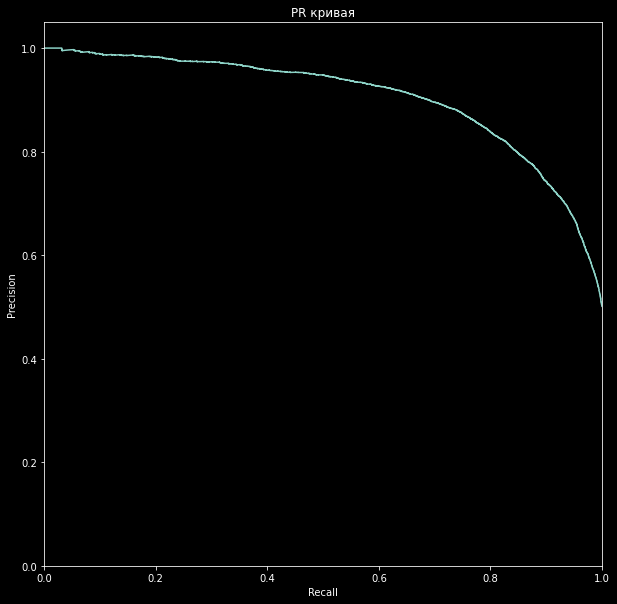

In [ ]:
model = SimpleLSTM(
    
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX
   
)

PATH = "/content/SimpleLSTM"
model.load_state_dict(torch.load(PATH))
model.to(device)

make_metrics(model, test_iter, grid=False)

Лучшие результаты достигаются при пороге равном `0.55`. Так или иначе - сравним с другими моделями

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


### nn.LSTM bidirectional

In [ ]:
class LSTMmodelPadded(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, 
                dropout, pad_idx, bidirectional=True):
      super().__init__()
      self.embedding = nn.Embedding(vocab_size, 
                                    embedding_dim,
                                    padding_idx=pad_idx)
      
      self.lstm = nn.LSTM(input_size=embedding_dim,
                          hidden_size=hidden_dim,
                          num_layers=num_layers,
                          dropout = dropout,
                          bidirectional=bidirectional)
      self.dropout = nn.Dropout(dropout)
      self.fc = nn.Linear(hidden_dim * 2, hidden_dim)
      self.fc_out = nn.Linear(hidden_dim, output_dim)
      
  def forward(self, text, text_lengths):
      embedded = self.embedding(text)
      packed = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to("cpu"))
      packed_output, (hidden, cell) = self.lstm(packed)
      hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
      outputs = self.fc(hidden.squeeze(0))
      outputs = self.fc_out(self.dropout(outputs))
      return outputs

In [ ]:
# определяем гиперпараметры модели
vocab_size = len(TEXT.vocab) + 1
emb_dim = 300
hidden_dim = 128
output_dim = 1
num_layers = 2
dropout = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
bidirectional=True

# создаем модель

model = LSTMmodelPadded(
    
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX
   
)

print(f'У модели{cnt_params(model): } обучаемых параметров')

# переносим на девайс и определяем оптимизатор
model = model.to(device)
opt = torch.optim.Adam(model.parameters())

У модели 61331509 обучаемых параметров


In [ ]:
train(model, train_iter, valid_iter, opt, padded=True)

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.57, accuracy: 0.72


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.49, accuracy: 0.76


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.78, accuracy: 0.72


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.56, accuracy: 0.79


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.77, accuracy: 0.78


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 1.06, accuracy: 0.76


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.88, accuracy: 0.81


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 1.10, accuracy: 0.80
Средняя Accuracy - 0.77


Лучшее `accuracy` получилось `0.77` - сопоставимо и может быть в силу случайности.   

Загрузим нашу модель и посмотрим `f_1` при разных порогах и оценим `PR-curve` на тестовой выборке

  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.00 | Точность = 0.500, Полнота = 1.000 | F1-мера = 0.667


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.05 | Точность = 0.548, Полнота = 0.989 | F1-мера = 0.705


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.10 | Точность = 0.598, Полнота = 0.965 | F1-мера = 0.738


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.15 | Точность = 0.638, Полнота = 0.932 | F1-мера = 0.757


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.20 | Точность = 0.674, Полнота = 0.897 | F1-мера = 0.770


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.25 | Точность = 0.704, Полнота = 0.856 | F1-мера = 0.773


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.30 | Точность = 0.732, Полнота = 0.818 | F1-мера = 0.772


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.35 | Точность = 0.755, Полнота = 0.776 | F1-мера = 0.766


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.40 | Точность = 0.778, Полнота = 0.735 | F1-мера = 0.756


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.45 | Точность = 0.802, Полнота = 0.695 | F1-мера = 0.744


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.50 | Точность = 0.822, Полнота = 0.654 | F1-мера = 0.728


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.55 | Точность = 0.839, Полнота = 0.608 | F1-мера = 0.705


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.60 | Точность = 0.857, Полнота = 0.555 | F1-мера = 0.673


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.65 | Точность = 0.877, Полнота = 0.508 | F1-мера = 0.643


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.70 | Точность = 0.897, Полнота = 0.453 | F1-мера = 0.602


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.75 | Точность = 0.913, Полнота = 0.394 | F1-мера = 0.550


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.80 | Точность = 0.933, Полнота = 0.330 | F1-мера = 0.488


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.85 | Точность = 0.950, Полнота = 0.258 | F1-мера = 0.406


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.90 | Точность = 0.963, Полнота = 0.176 | F1-мера = 0.298
Мера для стандартного порога: 0.73


  0%|          | 0/391 [00:00<?, ?it/s]

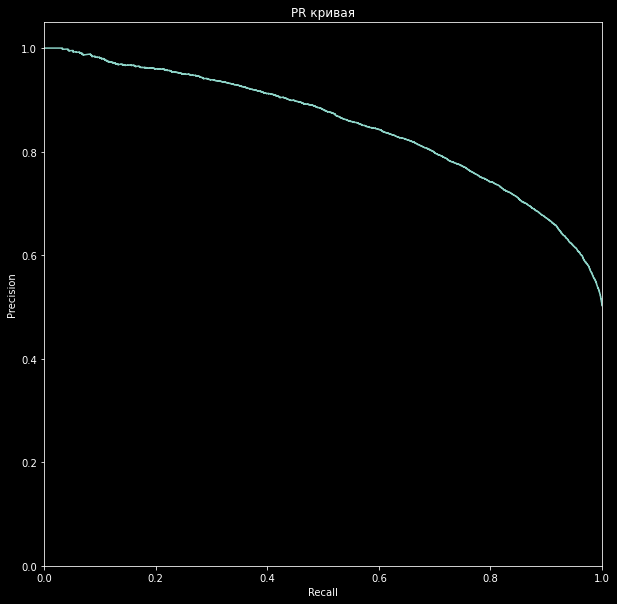

In [ ]:
model = LSTMmodelPadded(
    
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_layers=num_layers,
    dropout=dropout,
    pad_idx = PAD_IDX
   
)

PATH = "/content/LSTMmodelPadded"
model.load_state_dict(torch.load(PATH))
model.to(device)

make_metrics(model, test_iter, grid=False, padded=True)

Лучшая мера F1 при пороге `0.3`, при стандартном пороге `0.5` - `0.78`

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


### Custom LSTM

Попробуем сделать `Naive LSTM`. Посмотрим результаты, затем сравним с готовой моделью из `torch`

<p align="center"><img src="https://drive.google.com/uc?id=1mHMEd47qUwasTH-y8arZeE6nYeyqiJCf" alt="w2v" border="0"></a></p>




In [ ]:
class CustomLSTM(nn.Module):
  def __init__(self, embed_dim: int, hidden_dim: int):
        super().__init__()

        self.embed_size = embed_dim
        self.hidden_dim = hidden_dim

        # i_t

        self.w_i = nn.Parameter(torch.rand(embed_dim, hidden_dim))
        self.b_i = nn.Parameter(torch.rand((1, hidden_dim)))
        self.w_ih = nn.Parameter(torch.rand(hidden_dim, hidden_dim))
        self.b_ih = nn.Parameter(torch.rand((1, hidden_dim)))
    
        # f_t

        self.w_f = nn.Parameter(torch.rand(embed_dim, hidden_dim))
        self.b_f = nn.Parameter(torch.rand((1, hidden_dim)))
        self.w_fh = nn.Parameter(torch.rand(hidden_dim, hidden_dim))
        self.b_fh = nn.Parameter(torch.rand((1, hidden_dim)))

        # g_t

        self.w_g = nn.Parameter(torch.rand(embed_dim, hidden_dim))
        self.b_g = nn.Parameter(torch.rand((1, hidden_dim)))
        self.w_gh = nn.Parameter(torch.rand(hidden_dim, hidden_dim))
        self.b_gh = nn.Parameter(torch.rand((1, hidden_dim)))

        # o_t

        self.w_o = nn.Parameter(torch.rand(embed_dim, hidden_dim))
        self.b_o = nn.Parameter(torch.rand((1, hidden_dim)))
        self.w_oh = nn.Parameter(torch.rand(hidden_dim, hidden_dim))
        self.b_oh = nn.Parameter(torch.rand((1, hidden_dim)))

        self.init_weights()

  # для инициализации весов
  # без этого результаты сильно хуже
  
  def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_dim)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)


  def forward(self, x, init_states = None):
        sequence, batch, _ = x.size()
        hidden_seq = []

        if init_states is None:
          h_t, c_t = (
              
              torch.zeros(batch, self.hidden_dim).to(x.device),
              torch.zeros(batch, self.hidden_dim).to(x.device),
          )

        else:
          h_t, c_t = init_states

        for cur_idx in range(sequence):

          x_t = x[cur_idx, :, :]
          i_t = torch.sigmoid(x_t @ self.w_i + self.b_i + h_t @ self.w_ih + self.b_fh)
          f_t = torch.sigmoid(x_t @ self.w_f + self.b_f + h_t @ self.w_fh + self.b_fh)
          g_t = torch.tanh(x_t @ self.w_g + self.b_g + h_t @ self.w_gh + self.b_gh)
          o_t = torch.sigmoid(x_t @ self.w_o + self.b_o + h_t @ self.w_oh + self.b_oh)
          c_t = f_t * c_t + i_t * g_t
          h_t = o_t * torch.tanh(c_t)

        hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [ ]:
class LSTMmodelCustom(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                dropout, pad_idx):
      super().__init__()
      self.embedding = nn.Embedding(vocab_size, 
                                    embedding_dim,
                                    padding_idx=pad_idx)
      
      self.lstm = CustomLSTM(embed_dim=embedding_dim,
                             hidden_dim=hidden_dim)
      self.dropout = nn.Dropout(dropout)
      self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, text, text_lengths):
      embedded = self.embedding(text)
      output, (hidden, cell) = self.lstm(embedded) 
      output = output[:, -1, :]
      outputs = self.fc(self.dropout(output))
      return outputs

In [ ]:
# определяем гиперпараметры модели
vocab_size = len(TEXT.vocab)
emb_dim = 300
hidden_dim = 128
output_dim = 1
dropout = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]


# создаем модель

model = LSTMmodelCustom(
    
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    dropout=dropout,
    pad_idx=PAD_IDX,
)

print(f'У модели{cnt_params(model): } обучаемых параметров')

# переносим на девайс и определяем оптимизатор
model = model.to(device)
opt = torch.optim.Adam(model.parameters())

У модели 60682889 обучаемых параметров


In [ ]:
train(model, train_iter, valid_iter, opt, padded=True)

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.59, accuracy: 0.70


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.62, accuracy: 0.73


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.51, accuracy: 0.77


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.76, accuracy: 0.76


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.78, accuracy: 0.79


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 1.01, accuracy: 0.75


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 0.95, accuracy: 0.77


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 1.05, accuracy: 0.77


  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Valid Loss: 1.25, accuracy: 0.75
Средняя Accuracy - 0.75


Модель обучалась достаточно долго, относительно других. Необходимы оптимизации в `LSTM`, написанной нами - слишком много матричных умножений и параметров

  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.00 | Точность = 0.500, Полнота = 1.000 | F1-мера = 0.667


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.05 | Точность = 0.571, Полнота = 0.976 | F1-мера = 0.720


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.10 | Точность = 0.607, Полнота = 0.956 | F1-мера = 0.743


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.15 | Точность = 0.631, Полнота = 0.942 | F1-мера = 0.755


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.20 | Точность = 0.648, Полнота = 0.927 | F1-мера = 0.763


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.25 | Точность = 0.663, Полнота = 0.913 | F1-мера = 0.768


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.30 | Точность = 0.678, Полнота = 0.899 | F1-мера = 0.773


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.35 | Точность = 0.692, Полнота = 0.885 | F1-мера = 0.777


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.40 | Точность = 0.704, Полнота = 0.872 | F1-мера = 0.779


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.45 | Точность = 0.716, Полнота = 0.857 | F1-мера = 0.780


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.50 | Точность = 0.728, Полнота = 0.842 | F1-мера = 0.781


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.55 | Точность = 0.741, Полнота = 0.822 | F1-мера = 0.779


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.60 | Точность = 0.757, Полнота = 0.791 | F1-мера = 0.773


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.65 | Точность = 0.771, Полнота = 0.763 | F1-мера = 0.767


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.70 | Точность = 0.787, Полнота = 0.733 | F1-мера = 0.759


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.75 | Точность = 0.804, Полнота = 0.697 | F1-мера = 0.746


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.80 | Точность = 0.824, Полнота = 0.655 | F1-мера = 0.730


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.85 | Точность = 0.843, Полнота = 0.600 | F1-мера = 0.701


  0%|          | 0/391 [00:00<?, ?it/s]

Порог = 0.90 | Точность = 0.869, Полнота = 0.520 | F1-мера = 0.651
Мера для стандартного порога: 0.78


  0%|          | 0/391 [00:00<?, ?it/s]

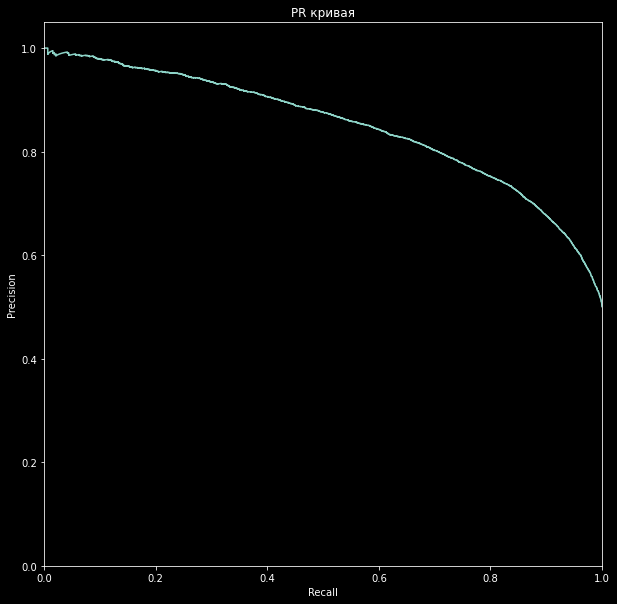

In [ ]:
model = LSTMmodelCustom(
    
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    dropout=dropout,
    pad_idx=PAD_IDX,
)



PATH = "/content/LSTMmodelCustom"
model.load_state_dict(torch.load(PATH))
model.to(device)

make_metrics(model, test_iter, grid=False, padded=True)

### Вывод

f1-score нашего классификатора на тестовом датасете:


Результаты экспериментов:


```python

------
1. SimpleLSTM: Средняя Accuracy на валидации - 0.79, F1-мера для стандартного порога на тестовом сете: 0.80
2. LSTMmodelPadded: Средняя Accuracy на валидации - 0.77, F1-мера для стандартного порога на тестовом сете: 0.73
3. CustomLSTM: Средняя Accuracy на валидации - 0.75, F1-мера для стандартного порога на тестовом сете: 0.78

```

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


## CNN

![](https://www.researchgate.net/publication/333752473/figure/fig1/AS:769346934673412@1560438011375/Standard-CNN-on-text-classification.png)

Для классификации текстов также часто используют сверточные нейронные сети. Идея в том, что как правило сентимент содержат словосочетания из двух-трех слов, например "очень хороший фильм" или "невероятная скука". Проходясь сверткой по этим словам мы получим какой-то большой скор и выхватим его с помощью MaxPool. Далее идет обычная полносвязная сетка. Важный момент: свертки применяются не последовательно, а параллельно.  Подгтовим данные и функции для обучения сверточной нейронной сети для задачи классификации текста

In [ ]:
SEED = 42

TEXT = data.Field(sequential=True, lower=True, batch_first=True)
LABEL = data.LabelField(batch_first=True, dtype=torch.float)

train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

TEXT.build_vocab(trn)
LABEL.build_vocab(trn)

device = "cuda" if torch.cuda.is_available() else "cpu"

Грузим сеты и опредялем функции

In [ ]:
train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

In [ ]:
# для обучения
def train(model, 
        train_loader, 
        val_loader, 
        opt, 
        criterion: torch.nn = nn.BCEWithLogitsLoss(),
        patience: int = 5, 
        max_grad_norm: int = 1, 
        max_epochs: int = 42
        ) -> None:

  """функция для обучения сети"""
  all_acc = []
  best_val_loss = np.inf
  patience_count = 0
  best_model = copy.deepcopy(model.state_dict())
  for epoch in range(1, max_epochs + 1):
      train_loss = 0.0
      model.train()
      pbar = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
      pbar.set_description(f"Epoch {epoch}")

      for it, batch in pbar: 
        labels = batch.label.unsqueeze(1)
        features = batch.text
        preds = model(features)
        loss = criterion(preds, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        opt.step()

      val_loss = 0.0
      num_iter = 0
      model.eval()
      with torch.no_grad():
        correct = 0
        nums = 0
        pbar = tqdm(enumerate(val_loader), total=len(val_loader), leave=False)
        pbar.set_description(f"Epoch {epoch}")
        for it, batch in pbar:
          labels = batch.label.unsqueeze(1)
          features = batch.text
          prediction = model(features)
          val_loss += criterion(prediction, labels)
          probs = torch.sigmoid(prediction)
          preds = ((probs > 0.5) * 1.)
          correct += (preds == labels.data).sum().item()
          nums += labels.size(0)
          num_iter += 1
      valid_loss = val_loss / num_iter
      acc = correct/nums
      print(f"Valid Loss: {valid_loss:.2f}, accuracy: {acc:.2f}")
      all_acc.append(acc)
      if(best_val_loss > val_loss):
        patience_count = 0
        best_val_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())
      if patience is not None:
        if(patience_count > patience):
          break
      patience_count += 1
  model.load_state_dict(best_model)
  torch.save(best_model, f'/content/{model.__class__.__name__}')   
  mean_acc = np.mean(all_acc)
  print(f"Средняя Accuracy - {mean_acc:.2f}")

In [ ]:
# для проверки метрик: precision, recall, f1, pr-curve

def make_metrics(model, test_loader, grid=True):
  model.eval()
  for threshold in np.arange(0, 0.95, 0.05):
    y_pred = []
    y_true = []
    pbar = tqdm(enumerate(test_loader), total=len(test_loader), leave=False)
    for _, batch in pbar:
      labels = batch.label.unsqueeze(1)
      features = batch.text
      outputs = model(features)
      probs = torch.sigmoid(outputs)
      y_preds = ((probs > threshold) * 1.)
      y_pred.extend(y_preds.detach().to('cpu').numpy())
      y_true.extend(labels.to('cpu').numpy())
    f_score = f1_score(y_true, y_pred)
    if threshold == .5:
      f1 = f_score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f} | F1-мера = {:.3f}".format(
          threshold, precision, recall, f_score))
    
  print(f"\033[1mМера для стандартного порога: {f1:.2f}\033[0m")

  y_probs = []
  y_true = []

  pbar = tqdm(enumerate(test_loader), total=len(test_loader), leave=False)
  with plt.style.context('dark_background'):
    for _, batch in pbar:
      labels = batch.label.unsqueeze(1)
      features = batch.text
      outputs = model(features)
      probs = torch.sigmoid(outputs)
      y_probs.extend(probs.detach().to('cpu').numpy())
      y_true.extend(labels.to('cpu').numpy())

    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)    
    plt.figure(figsize=(10, 10))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('PR кривая')
    plt.grid(grid)
    plt.show() 


Можно использовать Conv2d с `in_channels=1, kernel_size=(kernel_sizes[0], emb_dim))` или Conv1d c `in_channels=emb_dim, kernel_size=kernel_size[0]`

In [ ]:
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_dim,
        out_channels,
        kernel_sizes
    ):
        super().__init__()
        

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.conv_list = nn.ModuleList([
                                     nn.Conv2d(in_channels=1,
                                              out_channels=out_channels,
                                              kernel_size=(ks, emb_dim))
                                              for ks in kernel_sizes
              ])
       
        self.norm = nn.BatchNorm2d(out_channels)                           
        self.fc = nn.Linear(len(kernel_sizes) * out_channels, 1)
        
        
        
    def forward(self, text):
        
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        conved_out = [F.relu(conv(embedded)).squeeze(3) if idx ==0 \
                      else F.relu(self.norm(conv(embedded)).squeeze(3)) for \
                      idx, conv in enumerate(self.conv_list)]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved_out]
        cat = torch.cat(pooled, dim=1)
        return self.fc(cat)

In [ ]:
# определяем гиперпараметры модели
kernel_sizes = [2, 3, 4]
vocab_size = len(TEXT.vocab)
out_channels = 64
dim = 300


# создаем модель

model = TextCNN(vocab_size=vocab_size, 
            emb_dim=dim, 
            out_channels=out_channels,
            kernel_sizes=kernel_sizes)


print(f'У модели{cnt_params(model): } обучаемых параметров')

# переносим на девайс и определяем оптимизатор
model = model.to(device)
opt = torch.optim.Adam(model.parameters())

У модели 60635913 обучаемых параметров


Наконец, мы можем обучить нашу сеть и посмотреть результаты, сравнив с другими моделями

In [ ]:
train(model, train_iter, val_iter, opt)

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.43, accuracy: 0.80


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.39, accuracy: 0.82


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.38, accuracy: 0.83


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.34, accuracy: 0.85


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.33, accuracy: 0.86


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.35, accuracy: 0.85


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.35, accuracy: 0.86


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.43, accuracy: 0.84


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.39, accuracy: 0.86


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.58, accuracy: 0.82


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.90, accuracy: 0.78
Средняя Accuracy - 0.83


Здесь результаты значительно лучше, чем при использовании `RNN` для классификации текстов

  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.00 | Точность = 0.500, Полнота = 1.000 | F1-мера = 0.667


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.05 | Точность = 0.658, Полнота = 0.981 | F1-мера = 0.788


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.10 | Точность = 0.709, Полнота = 0.965 | F1-мера = 0.818


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.15 | Точность = 0.743, Полнота = 0.950 | F1-мера = 0.834


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.20 | Точность = 0.769, Полнота = 0.937 | F1-мера = 0.845


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.25 | Точность = 0.791, Полнота = 0.922 | F1-мера = 0.851


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.30 | Точность = 0.809, Полнота = 0.906 | F1-мера = 0.855


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.35 | Точность = 0.825, Полнота = 0.891 | F1-мера = 0.856


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.40 | Точность = 0.840, Полнота = 0.877 | F1-мера = 0.858


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.45 | Точность = 0.854, Полнота = 0.862 | F1-мера = 0.858


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.50 | Точность = 0.867, Полнота = 0.845 | F1-мера = 0.856


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.55 | Точность = 0.878, Полнота = 0.826 | F1-мера = 0.851


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.60 | Точность = 0.891, Полнота = 0.807 | F1-мера = 0.847


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.65 | Точность = 0.902, Полнота = 0.783 | F1-мера = 0.838


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.70 | Точность = 0.910, Полнота = 0.759 | F1-мера = 0.828


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.75 | Точность = 0.922, Полнота = 0.732 | F1-мера = 0.816


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.80 | Точность = 0.933, Полнота = 0.699 | F1-мера = 0.799


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.85 | Точность = 0.947, Полнота = 0.655 | F1-мера = 0.775


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.90 | Точность = 0.959, Полнота = 0.596 | F1-мера = 0.735
Мера для стандартного порога: 0.86


  0%|          | 0/98 [00:00<?, ?it/s]

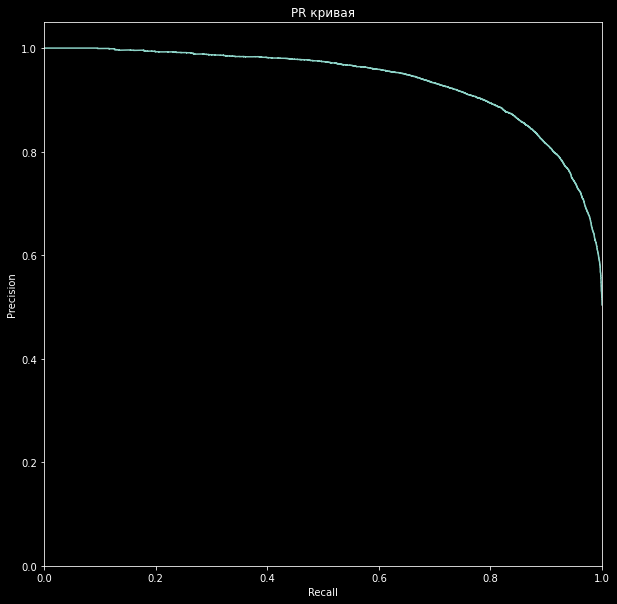

In [ ]:
kernel_sizes = [2, 3, 4]
vocab_size = len(TEXT.vocab)
out_channels = 64
dropout = 0.5
dim = 300


model = TextCNN(vocab_size=vocab_size, 
            emb_dim=dim, 
            out_channels=out_channels,
            kernel_sizes=kernel_sizes)



PATH = "/content/TextCNN"
model.load_state_dict(torch.load(PATH))
model.to(device)

make_metrics(model, test_iter, grid=False)

### Вывод

f1-score нашего классификатора на тестовом датасете:


Результаты экспериментов:


```python

4. TextCNN: Средняя Accuracy на валидации - 0.78, F1-мера для стандартного порога на тестовом сете: 0.83


Ниже приведеные результаты других подходов к решению задачи


------
1. SimpleLSTM: Средняя Accuracy на валидации - 0.79, F1-мера для стандартного порога на тестовом сете: 0.80
2. LSTMmodelPadded: Средняя Accuracy на валидации - 0.77, F1-мера для стандартного порога на тестовом сете: 0.73
3. CustomLSTM: Средняя Accuracy на валидации - 0.75, F1-мера для стандартного порога на тестовом сете: 0.78

```

Сверточная сеть лучше справилась с задачей классификации текста

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


## Интерпретируемость

Посмотрим, куда смотрит наша модель - попробуем интерпритировать результаты

In [ ]:
PAD_IND = TEXT.vocab.stoi['pad']
token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model, model.embedding)

In [ ]:
vis_data_records_ig = []

interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)
interpret_sentence(model, 'I love Matrix!', label=1)
interpret_sentence(model, 'I hate this movie!', label=0)

pred:  pos ( 0.24 ) , delta:  tensor([2.1302e-05], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.31 ) , delta:  tensor([9.7429e-05], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.01 ) , delta:  tensor([4.5406e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.98 ) , delta:  tensor([0.0001], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.99 ) , delta:  tensor([1.8252e-05], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.27 ) , delta:  tensor([0.0001], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.03 ) , delta:  tensor([3.3865e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.80 ) , delta:  tensor([0.0003], device='cuda:0', dtype=torch.float64)


In [ ]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
neg,pos (0.24),neg,-0.15,It was a fantastic performance ! pad
neg,pos (0.31),neg,-0.42,Best film ever pad pad pad pad
neg,pos (0.01),neg,-1.20,Such a great show! pad pad pad
pos,neg (0.98),neg,1.06,It was a horrible movie pad pad
pos,neg (0.99),neg,1.01,I've never watched something as bad pad
pos,pos (0.27),neg,-0.29,It is a disgusting movie! pad pad
neg,pos (0.03),neg,-0.92,I love Matrix! pad pad pad pad
pos,neg (0.80),neg,1.82,I hate this movie! pad pad pad


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
neg,pos (0.24),neg,-0.15,It was a fantastic performance ! pad
neg,pos (0.31),neg,-0.42,Best film ever pad pad pad pad
neg,pos (0.01),neg,-1.20,Such a great show! pad pad pad
pos,neg (0.98),neg,1.06,It was a horrible movie pad pad
pos,neg (0.99),neg,1.01,I've never watched something as bad pad
pos,pos (0.27),neg,-0.29,It is a disgusting movie! pad pad
neg,pos (0.03),neg,-0.92,I love Matrix! pad pad pad pad
pos,neg (0.80),neg,1.82,I hate this movie! pad pad pad


А здесь все выглядит не так гладко - не все слова, которые являются для модели негативными - можно таковыми назвать

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


## Эмбеддинги слов

Применим заморозку эмбеддингов

In [ ]:
SEED = 42

TEXT = data.Field(sequential=True, lower=True, batch_first=True)
LABEL = data.LabelField(batch_first=True, dtype=torch.float)

train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=300))
LABEL.build_vocab(trn)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

In [ ]:
def freezeit(model, req_grad=False):
    """для заморозки весов эмбеддингов"""
    embeddings = model.embedding
    for p in embeddings.parameters():
        p.requires_grad = req_grad

In [ ]:
# определяем гиперпараметры модели
kernel_sizes = [2, 3, 4]
vocab_size = len(TEXT.vocab)
out_channels = 64
dim = 300

# создаем модель

model = TextCNN(vocab_size=vocab_size, 
            emb_dim=dim, 
            out_channels=out_channels,
            kernel_sizes=kernel_sizes)



freezeit(model)
prev_shape = model.embedding.weight.shape
assert prev_shape == model.embedding.weight.shape
word_embeddings = TEXT.vocab.vectors
print(f'У модели{cnt_params(model): } обучаемых параметров')

# переносим на девайс и определяем оптимизатор
model = model.to(device)
opt = torch.optim.Adam(model.parameters())

У модели 173313 обучаемых параметров


Добавим в функцию обучения возможность заморозки и разморозки весов эмбеддингов

In [ ]:
# для обучения
def train_freezer(model, 
        train_loader, 
        val_loader, 
        opt, 
        criterion: torch.nn = nn.BCEWithLogitsLoss(),
        num_freeze_epoch = 1,
        patience: int = 5, 
        max_grad_norm: int = 1, 
        max_epochs: int = 42
        ) -> None:

  """функция для обучения сети"""
  all_acc = []
  best_val_loss = np.inf
  patience_count = 0
  best_model = copy.deepcopy(model.state_dict())
  flag = 1
  for epoch in range(1, max_epochs + 1):
      train_loss = 0.0
      model.train()
      pbar = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
      pbar.set_description(f"Epoch {epoch}")

      for it, batch in pbar: 
        if epoch == num_freeze_epoch + 1 and flag == 1:
          flag -= 1
          print("Defreeze weights of embeddings...Done")
          freezeit(model, True)

        labels = batch.label.unsqueeze(1)
        features = batch.text
        preds = model(features)
        loss = criterion(preds, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        opt.step()
        
      val_loss = 0.0
      num_iter = 0
      model.eval()
      with torch.no_grad():
        correct = 0
        nums = 0
        pbar = tqdm(enumerate(val_loader), total=len(val_loader), leave=False)
        pbar.set_description(f"Epoch {epoch}")
        for it, batch in pbar:
          labels = batch.label.unsqueeze(1)
          features = batch.text
          prediction = model(features)
          val_loss += criterion(prediction, labels)
          probs = torch.sigmoid(prediction)
          preds = ((probs > 0.5) * 1.)
          correct += (preds == labels.data).sum().item()
          nums += labels.size(0)
          num_iter += 1
      valid_loss = val_loss / num_iter
      acc = correct/nums
      print(f"Valid Loss: {valid_loss:.2f}, accuracy: {acc:.2f}")
      all_acc.append(acc)
      if(best_val_loss > val_loss):
        patience_count = 0
        best_val_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())
      if patience is not None:
        if(patience_count > patience):
          break
      patience_count += 1
  model.load_state_dict(best_model)
  torch.save(best_model, f'/content/{model.__class__.__name__}')   
  mean_acc = np.mean(all_acc)
  print(f"Средняя Accuracy - {mean_acc:.2f}")

In [ ]:
train_freezer(model, train_iter, val_iter, opt)

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.50, accuracy: 0.75


  0%|          | 0/137 [00:00<?, ?it/s]

Defreeze weights of embeddings...Done


  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.41, accuracy: 0.80


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.36, accuracy: 0.84


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.34, accuracy: 0.85


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.44, accuracy: 0.81


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.44, accuracy: 0.82


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.34, accuracy: 0.86


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.37, accuracy: 0.86


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.40, accuracy: 0.86


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.82, accuracy: 0.77


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.69, accuracy: 0.80


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.88, accuracy: 0.78


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Valid Loss: 0.84, accuracy: 0.80
Средняя Accuracy - 0.82


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.00 | Точность = 0.500, Полнота = 1.000 | F1-мера = 0.667


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.05 | Точность = 0.662, Полнота = 0.982 | F1-мера = 0.791


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.10 | Точность = 0.703, Полнота = 0.969 | F1-мера = 0.815


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.15 | Точность = 0.730, Полнота = 0.957 | F1-мера = 0.828


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.20 | Точность = 0.750, Полнота = 0.946 | F1-мера = 0.837


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.25 | Точность = 0.769, Полнота = 0.936 | F1-мера = 0.844


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.30 | Точность = 0.784, Полнота = 0.925 | F1-мера = 0.849


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.35 | Точность = 0.797, Полнота = 0.916 | F1-мера = 0.853


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.40 | Точность = 0.811, Полнота = 0.906 | F1-мера = 0.856


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.45 | Точность = 0.823, Полнота = 0.898 | F1-мера = 0.859


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.50 | Точность = 0.833, Полнота = 0.888 | F1-мера = 0.859


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.55 | Точность = 0.844, Полнота = 0.877 | F1-мера = 0.860


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.60 | Точность = 0.855, Полнота = 0.863 | F1-мера = 0.859


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.65 | Точность = 0.865, Полнота = 0.848 | F1-мера = 0.857


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.70 | Точность = 0.876, Полнота = 0.832 | F1-мера = 0.853


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.75 | Точность = 0.887, Полнота = 0.812 | F1-мера = 0.848


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.80 | Точность = 0.901, Полнота = 0.788 | F1-мера = 0.841


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.85 | Точность = 0.911, Полнота = 0.754 | F1-мера = 0.825


  0%|          | 0/98 [00:00<?, ?it/s]

Порог = 0.90 | Точность = 0.927, Полнота = 0.712 | F1-мера = 0.805
Мера для стандартного порога: 0.86


  0%|          | 0/98 [00:00<?, ?it/s]

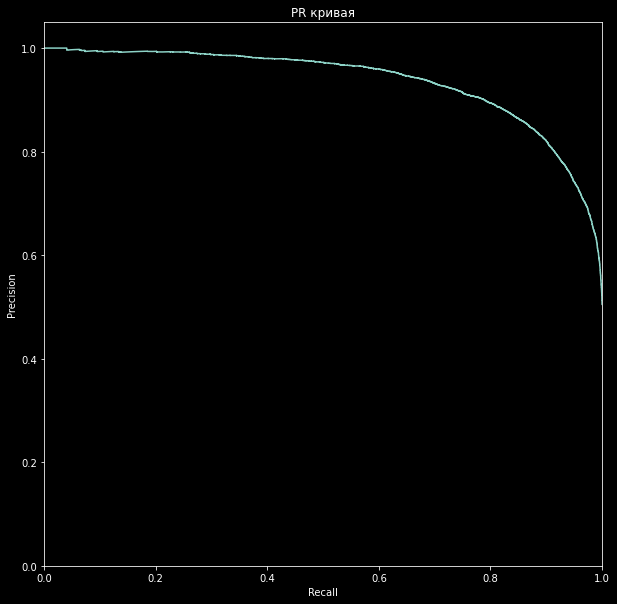

In [ ]:
kernel_sizes = [2, 3, 4]
vocab_size = len(TEXT.vocab)
out_channels = 64
dropout = 0.5
dim = 300


model = TextCNN(vocab_size=vocab_size, 
            emb_dim=dim, 
            out_channels=out_channels,
            kernel_sizes=kernel_sizes)



PATH = "/content/TextCNN"
model.load_state_dict(torch.load(PATH))
model.to(device)

make_metrics(model, test_iter, grid=False)

### Вывод

f1-score нашего классификатора на тестовом датасете:


Результаты экспериментов:


```python


5. TextCNN + embeddings: Средняя Accuracy на валидации - 0.82, F1-мера для стандартного порога на тестовом сете: 0.86

Ниже приведеные результаты других подходов к решению задачи

------
1. SimpleLSTM: Средняя Accuracy на валидации - 0.79, F1-мера для стандартного порога на тестовом сете: 0.80
2. LSTMmodelPadded: Средняя Accuracy на валидации - 0.77, F1-мера для стандартного порога на тестовом сете: 0.73
3. CustomLSTM: Средняя Accuracy на валидации - 0.75, F1-мера для стандартного порога на тестовом сете: 0.78
4. TextCNN: Средняя Accuracy на валидации - 0.78, F1-мера для стандартного порога на тестовом сете: 0.83

```

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


Проверим насколько все хорошо - в прошлом подходе, при хороших результатах, казалось бы, судя по метрикам - в реальности модель не оказывалась достаточно точной

In [ ]:
PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model, model.embedding)
vis_data_records_ig = []

interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)
interpret_sentence(model, 'I love Matrix!', label=1)
interpret_sentence(model, 'I hate this movie!', label=0)

pred:  pos ( 0.05 ) , delta:  tensor([3.3374e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.81 ) , delta:  tensor([4.9390e-05], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.00 ) , delta:  tensor([0.0004], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.98 ) , delta:  tensor([0.0004], device='cuda:0', dtype=torch.float64)
pred:  neg ( 1.00 ) , delta:  tensor([0.0005], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.48 ) , delta:  tensor([0.0002], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.72 ) , delta:  tensor([0.0003], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.39 ) , delta:  tensor([3.4949e-05], device='cuda:0', dtype=torch.float64)


In [ ]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
neg,pos (0.05),neg,-1.25,It was a fantastic performance ! pad
neg,neg (0.81),neg,0.37,Best film ever pad pad pad pad
neg,pos (0.00),neg,-1.13,Such a great show! pad pad pad
pos,neg (0.98),neg,0.63,It was a horrible movie pad pad
pos,neg (1.00),neg,0.88,I've never watched something as bad pad
pos,pos (0.48),neg,-0.60,It is a disgusting movie! pad pad
neg,neg (0.72),neg,0.04,I love Matrix! pad pad pad pad
pos,pos (0.39),neg,-0.72,I hate this movie! pad pad pad


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
neg,pos (0.05),neg,-1.25,It was a fantastic performance ! pad
neg,neg (0.81),neg,0.37,Best film ever pad pad pad pad
neg,pos (0.00),neg,-1.13,Such a great show! pad pad pad
pos,neg (0.98),neg,0.63,It was a horrible movie pad pad
pos,neg (1.00),neg,0.88,I've never watched something as bad pad
pos,pos (0.48),neg,-0.60,It is a disgusting movie! pad pad
neg,neg (0.72),neg,0.04,I love Matrix! pad pad pad pad
pos,pos (0.39),neg,-0.72,I hate this movie! pad pad pad


<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


## Вывод

Мы рассмотрели два подхода для классификации тексто: с использованием `RNN` и `CNN`. Ниже представлены результаты исследования

```python
1. SimpleLSTM: Средняя Accuracy на валидации - 0.79, F1-мера для стандартного порога на тестовом сете: 0.80
2. LSTMmodelPadded: Средняя Accuracy на валидации - 0.77, F1-мера для стандартного порога на тестовом сете: 0.73
3. CustomLSTM: Средняя Accuracy на валидации - 0.75, F1-мера для стандартного порога на тестовом сете: 0.78
4. TextCNN: Средняя Accuracy на валидации - 0.78, F1-мера для стандартного порога на тестовом сете: 0.83
5. TextCNN + embeddings: Средняя Accuracy на валидации - 0.82, F1-мера для стандартного порога на тестовом сете: 0.86



```




Стоит отметить, что сверточные сети справляются с задачей классификации текстов лучше реккурентных, но при этом, несмотря на то, что метрики у нас выходит достаточно высокие, данные архитектуры все еще "не понимают" семантики текста, и зачастую слова, которые мы воспринимаем как позитивные - относят к негативным